In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Code Overview:
- First Task: Process the images from all of the datasets (akeic/bcc, bkl, mel, nv, vasc) into dataframes, reshape, augment, and batch
- Second Task: Train Model
- Third Task: Visualize Results

---
**Task 1:** Processing the images

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
import numpy as np

In [3]:
tf.random.set_seed(19)
np.random.seed(19)

In [4]:
# Import Data
data_name = "skin_cancer_master_gray_filtered_other_removed"
cancer_data = keras.utils.image_dataset_from_directory(data_name, labels="inferred", image_size=(600,450), batch_size=None)

Found 13741 files belonging to 5 classes.


In [5]:
# Split Data
cancer_data.shuffle(cancer_data.cardinality())
#Take 75% of images for training
train_images = cancer_data.take(9750)
#Split training set for validation set
val_images = train_images.skip(4875)

#Remaining 25% for test
test_images = cancer_data.skip(9750) 

In [6]:
#reshape images and one-hot encode
size = (196, 196)
train_ds = train_images.map(lambda x, y: (tf.image.resize(x, size), [int(y == index) for index in range(5)]))
validation_ds = val_images.map(lambda x, y: (tf.image.resize(x, size), [int(y == index) for index in range(5)]))
test_ds = test_images.map(lambda x, y: (tf.image.resize(x, size), [int(y == index) for index in range(5)]))

#Augment train_ds
flipped_ds = train_ds.map(lambda x, y: (tf.keras.layers.RandomFlip("horizontal")(x, training=True), y))
rotated_ds = train_ds.map(lambda x, y: (tf.keras.layers.RandomRotation(0.2)(x, training=True), y))
train_ds = train_ds.concatenate(flipped_ds).concatenate(rotated_ds)

In [7]:
## Setup prefetching of size 2
batch_size = 2
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=2)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=2)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=2)

---
**Task 2:** Define model and train

In [8]:
def build_model():
    # From Keras load the Xception model
    base_model = keras.applications.Xception(
        weights="imagenet",  # load the model with ImageNet weights
        input_shape=(196, 196, 3), 
        include_top=False, # Remove classifier layer
    )
    
    base_model.trainable = False
    
    # Define Keras sequential model
    inputs = keras.Input(shape=(196, 196, 3))
    # Rescale inputs from (0, 255) to range of (-1., +1.)
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    
    x = base_model(x, training=False)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256, activation='sigmoid')(x)
    outputs = keras.layers.Dense(5, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    
    return model

In [9]:
model = build_model()

epochs = 200
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback])

Epoch 1/200
14625/14625 [==============================] - 315s 21ms/step - loss: 0.9167 - categorical_accuracy: 0.6427 - val_loss: 0.8652 - val_categorical_accuracy: 0.6484
Epoch 2/200
14625/14625 [==============================] - 265s 18ms/step - loss: 0.8218 - categorical_accuracy: 0.6812 - val_loss: 0.8057 - val_categorical_accuracy: 0.6706
Epoch 3/200
14625/14625 [==============================] - 262s 18ms/step - loss: 0.7754 - categorical_accuracy: 0.7000 - val_loss: 0.8075 - val_categorical_accuracy: 0.6837
Epoch 4/200
14625/14625 [==============================] - 254s 17ms/step - loss: 0.7554 - categorical_accuracy: 0.7106 - val_loss: 0.7173 - val_categorical_accuracy: 0.7210
Epoch 5/200
14625/14625 [==============================] - 253s 17ms/step - loss: 0.7218 - categorical_accuracy: 0.7219 - val_loss: 0.7186 - val_categorical_accuracy: 0.7225
Epoch 6/200
14625/14625 [==============================] - 249s 17ms/step - loss: 0.7016 - categorical_accuracy: 0.7300 - val_loss

In [10]:
model.save(data_name + '.keras')

In [11]:
model = tf.keras.models.load_model(data_name + '.keras')

---
**Task 3:** Visualize Results

1/1 [==============================] - 9s 9s/step


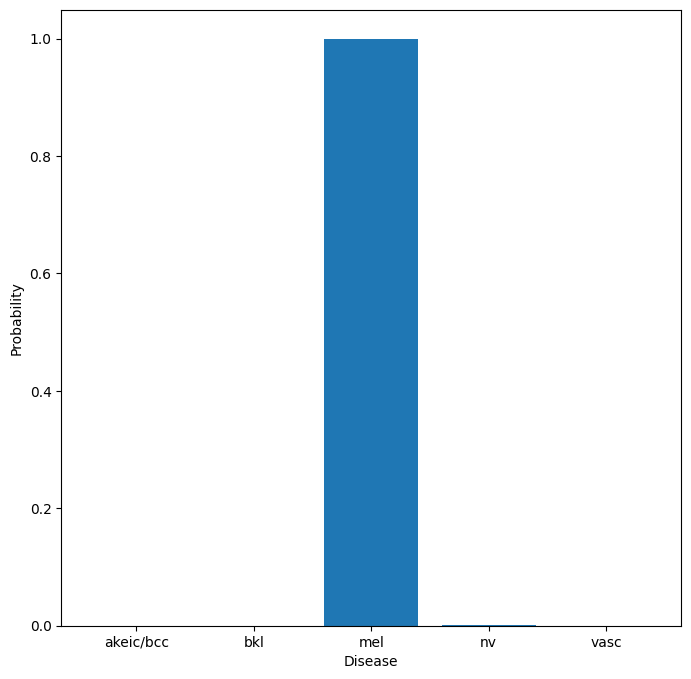

Actual: 2, Predicted: 2


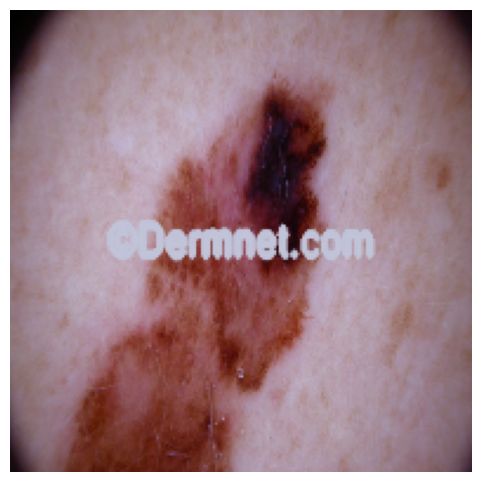

In [12]:
#Show one image example from the test set

import matplotlib.pyplot as plt

shuffled = test_ds.shuffle(test_ds.cardinality())

# Visualize results for first image from the first batch taken
for images, labels in shuffled.take(1):
    predicted_labels = model.predict(images)  # Predict labels for the batch

    # Normalize
    normalized_data = np.array(predicted_labels[0]) / sum(predicted_labels[0])
    
    # Plot the probability distribution for the first image
    plt.figure(figsize=(8, 8))
    plt.bar(range(len(normalized_data)), normalized_data)
    plt.xlabel('Disease')
    plt.ylabel('Probability')
    plt.xticks(range(len(normalized_data)), ["akeic/bcc", "bkl", "mel", "nv", "vasc"])
    plt.show()

    # Display the first image
    plt.figure(figsize=(6, 6))
    plt.imshow(images[0].numpy() / 255.0)  # Normalize
    print(f"Actual: {np.argmax(labels[0].numpy())}, Predicted: {np.argmax(predicted_labels[0])}")
    plt.axis('off')
    plt.show()


In [13]:
#Get all predictions
predictions = model.predict(test_ds, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

In [14]:
#Get true labels
true_labels = np.concatenate([labels.numpy() for _, labels in test_ds])
true_labels = np.argmax(true_labels, axis=1)

In [15]:
from sklearn.metrics import confusion_matrix

#Produce confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

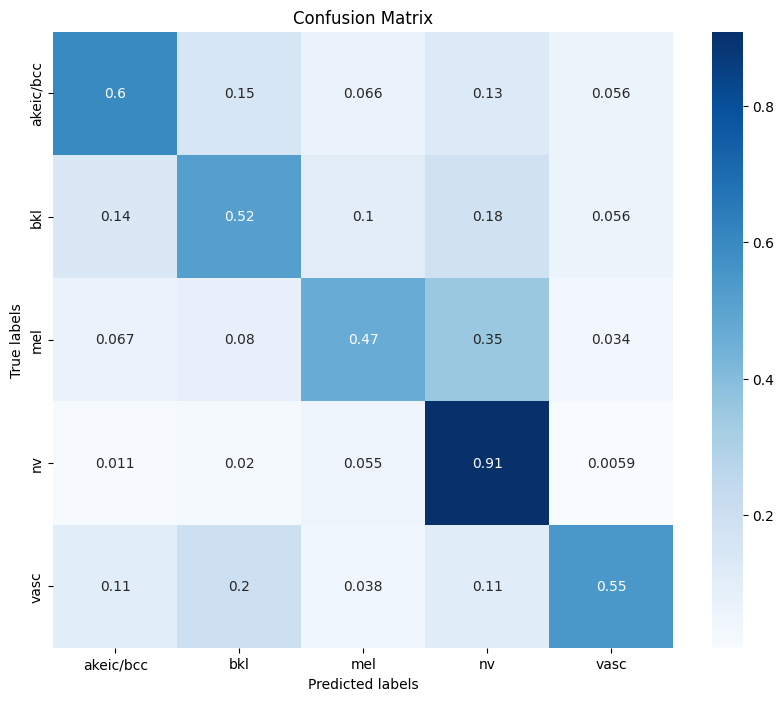

In [16]:
import seaborn as sns

#Visualize the cm
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", xticklabels=["akeic/bcc", "bkl", "mel", "nv", "vasc"], yticklabels=["akeic/bcc", "bkl", "mel", "nv", "vasc"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Print out model statistics

print(f"Accuracy: {accuracy_score(true_labels, predicted_labels, normalize=False) / len(true_labels)}")
print(f"Precision: {precision_score(true_labels, predicted_labels, average='macro')}")
print(f"Recall: {recall_score(true_labels, predicted_labels, average='macro')}")
print(f"F1 Score: {f1_score(true_labels, predicted_labels, average='macro')}")

Accuracy: 0.7246304184414933
Precision: 0.6239870216960688
Recall: 0.607404693602344
F1 Score: 0.6130325795360583
